Create Pandas Agent (scratch)

In [ ]:
import pandas as pd
# from langchain.prompts import StringPromptTemplate
# from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser, ZeroShotAgent

# from langchain_core.tools import tool
# from langchain.chains import LLMChain
# import operator
# from typing import TypedDict, Annotated, List, Union
from langchain_community.llms import Ollama
# from langchain_experimental.tools import PythonAstREPLTool
# from langchain.schema import AgentAction, AgentFinish
# import re
# import langchain

DF = pd.read_csv("../EDA/data/mac/Mac_2k.log_structured.csv")
df = DF
llm = Ollama(model = "llama3.1")




# ######
# #TOOL#
# ######
# from pydantic import BaseModel

# # Define the input schema
# class PythonToolInputSchema(BaseModel):
#     input:str
    
# python_tool = PythonAstREPLTool(locals={"df":DF})

# @tool()
# def python_tool(code: str) -> str:
#     """
#     This is a function that run python code for analysis.

#     Args:
#         input: (Str) A valid code.
#     """
#     # result = py.run(code)
#     # return result


# tools = [
#     Tool(
#         name = "python_tool",
#         func = python_tool.run,
#         description="""
#     This is a tool that executes Python code.

#     Args:
#         input: (str) A valid Python code string to execute.
#     """
#     ),
# ]





# #################
# #PROMPT TEMPLATE#
# #################

# template_1 =  """
# You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
# You should use the tools below to answer the question posed of you: {tools}"""

# template_2 = """
# This is the head of the data frame. `print(df.head(2))` To further analyse it use a tool:
# {df_head}

# Use the following format:

# Thought: you should always think about what to do
# Action: Must use [{tool_names}] tool
# Action Input: the input to the action
# Observation: the result of the action
# Thought: I now know the final answer
# Final Answer: the final answer to the original input queation
# """
# template_3= """
# Begin! 
# Question: {input}
# {agent_scratchpad}"""

# class CustomPromptTemplate(StringPromptTemplate):
#     template: str
#     tools: List[Tool]
    
#     def format(self, **kwargs) -> str:
#         #Get intermediate steps (AgentAction, Observation tuples)
        
#         intermediate_steps = kwargs.pop("intermediate_steps")
#         thoughts = ""
#         for action, observation in intermediate_steps:
#             thoughts += action.log
#             thoughts += f"\nObservation: {observation}\nThought: "
        
   
#         #Set agent_scratch pad variable ie agent reasoning
#         kwargs["agent_scratchpad"] = thoughts
#         #Create a tool variable from the list of tools provided
#         kwargs["tools"] = "\n".join(["f{tool.name}: {tool.description}" for tool in self.tools])
#         # Create a list of tool names for the tools provided
#         kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
#         kwargs["df_head"] = ''
#         return self.template.format(**kwargs)

    
# TEMPLATE = template_1 + template_3

# prompt_1 = CustomPromptTemplate(
#     template= TEMPLATE,
#     tools= tools,
#     input_variables= ["input", "intermediate_steps", "df_head"]
# ).partial(df_head = str(DF.head(2).to_markdown()))


# class CustomOutputParser(AgentOutputParser):
#     def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
#         if "Final Answer" in llm_output:
#             return AgentFinish(
#                 return_values={"output":llm_output.split("Final Answer:"[-1].strip())},
#                 log=llm_output
#             )
        
#         regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
#         match = re.search(regex, llm_output, re.DOTALL)
#         if not match:
#             return AgentAction(log=llm_output, tool = "non", tool_input="non")
#             raise ValueError(f"could not parse LLM output: `{llm_output}`")
#         action = match.group(1).strip()
#         action_input = match.group(2)
#         return AgentAction(tool = action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)
    
# output_parser = CustomOutputParser()



# ##############
# #CREATE AGENT#
# ##############

# llm_chain = LLMChain(llm = llm, prompt = prompt_1)
        
# tool_names = [tool.name for tool in tools]
# agent = ZeroShotAgent(
#     llm_chain=  llm_chain,
#     output_parser= output_parser,
#     stop = ["\nObservation:"],
#     allowed_tools = tool_names
# )

# agent_executor = AgentExecutor.from_agent_and_tools(
#     agent= agent,
#     tools=tools,
#     verbose = True,
#     max_iterations= 3,
# )



Langraph Example

In [23]:
import pandas as pd
from langchain_community.llms import Ollama
llm = Ollama(model="llama3.1")

DF = pd.read_csv("./data/mac/Mac_2k.log_structured.csv")

In [7]:
from langchain_core.tools import tool
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_experimental.tools import PythonAstREPLTool
@tool("search_tool", return_direct= True)
def search_tool(
    answer: str,
    ):
    """If you are Sure with your answer with this tool
    Returns a natural language response to the user in  `answer`"""
    
    return ""

tool = [PythonAstREPLTool(locals= {"df": DF})]
pd_agent = create_pandas_dataframe_agent(
    llm = llm,
    df = DF, 
    verbose = True, 
    return_intermediate_steps=True, 
    allow_dangerous_code=True
    )

In [20]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator


class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    
    
from langchain_core.agents import AgentFinish
import json
start_prefix = """
You are working with a pandas dataframe in Python. The name of the dataframe is `df`
This is the result of `print(df.head())`:
{df_head}."""

start_suffix ="""
Here is the Qustion:
{input}
Any out put code should be in the form ```python ```.

"""
#If yes output the python code with a print statement.

start_suffix2 ="""
Use the following format:
Thought: you should always think about what to do
Action: the action to take
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input queation
Begin!
Give me the python code with a print statement to solve the problem. Use the dataframe above do not create a new dataframe in your code. Here is the respective columns {df_columns}
Here is the Qustion:
{input}


"""
start_template = PromptTemplate.from_template("\n\n".join([start_prefix, start_suffix]))
df_head = str(DF.head(3).to_markdown())
start_template = start_template.partial(df_head=df_head)
def start_agent(state: list):
    print("start agent")
    llm = Ollama(model = "llama3.1")
    agent_out = start_template | llm
    out = agent_out.invoke(state)
    return {"agent_out": out}

def router(state:list):
    print("routing")
    llm = Ollama(model = "llama3.1")
    action = state["agent_out"]
    print(state['input'],'\n',state['agent_out'])
    out = llm.invoke(action + "is the code part related to the question. answer with a yes or a no only.")
    print(out)
    if 'yes' in out.lower():
        return "python_agent"
    else:
        return "final_agent"

def python_agent(state: list):
    print("python agent")
    llm = Ollama(model = "llama3.1")
    from langchain_experimental.agents import create_pandas_dataframe_agent
    from langchain_experimental.tools import PythonAstREPLTool
    tool = [PythonAstREPLTool(locals= {"df": DF})]
    pd_agent = create_pandas_dataframe_agent(llm = llm,df = DF, verbose = True, return_intermediate_steps=True, handle_parsing_errors=True, allow_dangerous_code=True, max_iterations=5)
    out = pd_agent.invoke(state['input'] + "format= ```python import pandas as pd ```")
    print(str(out))
    '''#text = state["agent_out"]
    python_agent_template = PromptTemplate.from_template(template = "\n\n".join([start_prefix, start_suffix2]))
    df_head = str(DF.head(3).to_markdown())
    df_columns = str(DF.columns)
    python_agent_template = python_agent_template.partial(df_head=df_head, df_columns=df_columns)
    agent = llm | python_agent_template
    text = agent.invoke(INPUT).text
    print("python_agent code:", text) '''
    text_output = out['output']
    print(text_output)
    return {"agent_out": text_output, 'input':state['input']}

def final_agent(state: list):
    llm = Ollama(model = "llama3.1")
    #action = state["agent_out"]
    print("final agent")
    out = llm.invoke(state['input'])
    return {"agent_out": out}
# Building the state graph
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("start_agent", start_agent)
graph.add_node("python_agent", python_agent)
graph.add_node('final_agent', final_agent)

graph.set_entry_point("start_agent")
graph.add_conditional_edges(
    source="start_agent",
    path = router
)

graph.add_edge("final_agent", END)
graph.add_edge("python_agent", END)
runnable = graph.compile()


In [21]:
# Call the compiled graph
out = runnable.invoke({"input": "What is the capital of Malaysia"})
print(out["agent_out"])

start agent
routing
What is the capital of Malaysia 
 It seems like you've provided a pandas dataframe `df` and asked about a completely unrelated question "What is the capital of Malaysia".

However, I can provide an answer to your question:

The capital of Malaysia is Kuala Lumpur.

As for any potential output code related to your original dataframe `df`, it would depend on what specific question or analysis you'd like to perform. If you have a particular task in mind, feel free to ask!
No
final agent
The capital of Malaysia is Kuala Lumpur.


In [26]:
out = runnable.invoke({"input": "How many row are there in the data"})
print(out["agent_out"])

start agent
routing
How many row are there in the data 
 ```python
print(len(df))
```

This will print the total number of rows in the dataframe `df`. Alternatively, you can also use:

```python
print(df.shape[0])
```

Both codes will give you the same result.


c:\Users\regan\Documents\NUS\NUS Modules\Year 4 Semester 1\BT4103\.venv\lib\site-packages\langchain_experimental\agents\agent_toolkits\pandas\base.py:283: UserWarning: Received additional kwargs {'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(
Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Yes
python agent
Thought: I need to find out how many rows are in the dataframe.

Action: Use `len(df)` to get the number of rows.

Action Input: None needed, just executing the commandUse `len(df)` to get the number of rows. is not a valid tool, try one of [python_repl_ast].Thought: I need to use the correct tool to execute the command.
Action: Use `python_repl_ast` to execute the command.

Action Input: len(dfUse `python_repl_ast` to execute the command. is not a valid tool, try one of [python_repl_ast].Thought: I need to use the correct format for input.
Action: Take the input and put it inside 'python_repl_ast'.
Action Input: len(dfTake the input and put it inside 'python_repl_ast'. is not a valid tool, try one of [python_repl_ast].I see what's going on here. You want to use the `len()` function to get the number of rows in the dataframe.

Let me correct that for you:

Action: Use `python_repl_ast` to execute the command with the input `len(df)`.

Action Input: `len(dfUse `python_r

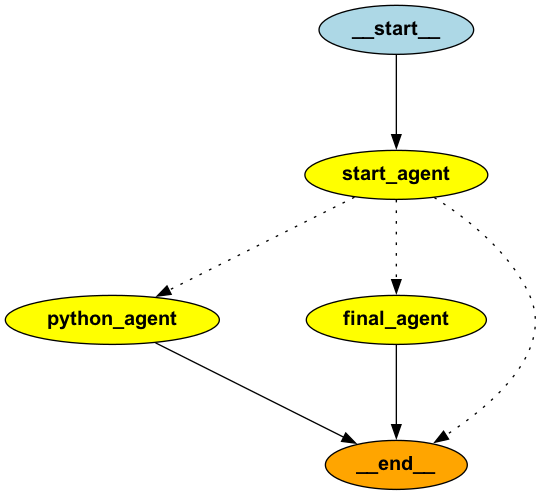

In [35]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

---

# Pandas Dataframe Agent Testing

In [1]:
"""Agent for working with pandas objects."""

import warnings
from typing import Any, Dict, List, Literal, Optional, Sequence, Union, cast

from langchain.agents import (
    AgentType,
    create_openai_tools_agent,
    create_react_agent,
    create_tool_calling_agent,
)
from langchain.agents.agent import (
    AgentExecutor,
    BaseMultiActionAgent,
    BaseSingleActionAgent,
    RunnableAgent,
    RunnableMultiActionAgent,
)
from langchain.agents.mrkl.prompt import FORMAT_INSTRUCTIONS
from langchain.agents.openai_functions_agent.base import (
    OpenAIFunctionsAgent,
    create_openai_functions_agent,
)
from langchain_core.callbacks import BaseCallbackManager
from langchain_core.language_models import BaseLanguageModel, LanguageModelLike
from langchain_core.messages import SystemMessage
from langchain_core.prompts import (
    BasePromptTemplate,
    ChatPromptTemplate,
    PromptTemplate,
)
from langchain_core.tools import BaseTool
from langchain_core.utils.interactive_env import is_interactive_env

from langchain_experimental.agents.agent_toolkits.pandas.prompt import (
    FUNCTIONS_WITH_DF,
    FUNCTIONS_WITH_MULTI_DF,
    MULTI_DF_PREFIX,
    MULTI_DF_PREFIX_FUNCTIONS,
    PREFIX,
    PREFIX_FUNCTIONS,
    SUFFIX_NO_DF,
    SUFFIX_WITH_DF,
    SUFFIX_WITH_MULTI_DF,
)
from langchain_experimental.tools.python.tool import PythonAstREPLTool


def _get_multi_prompt(
    dfs: List[Any],
    *,
    prefix: Optional[str] = None,
    suffix: Optional[str] = None,
    include_df_in_prompt: Optional[bool] = True,
    number_of_head_rows: int = 5,
) -> BasePromptTemplate:
    if suffix is not None:
        suffix_to_use = suffix
    elif include_df_in_prompt:
        suffix_to_use = SUFFIX_WITH_MULTI_DF
    else:
        suffix_to_use = SUFFIX_NO_DF
    prefix = prefix if prefix is not None else MULTI_DF_PREFIX

    template = "\n\n".join([prefix, "{tools}", FORMAT_INSTRUCTIONS, suffix_to_use])
    prompt = PromptTemplate.from_template(template)
    partial_prompt = prompt.partial()
    if "dfs_head" in partial_prompt.input_variables:
        dfs_head = "\n\n".join([d.head(number_of_head_rows).to_markdown() for d in dfs])
        partial_prompt = partial_prompt.partial(dfs_head=dfs_head)
    if "num_dfs" in partial_prompt.input_variables:
        partial_prompt = partial_prompt.partial(num_dfs=str(len(dfs)))
    return partial_prompt


def _get_single_prompt(
    df: Any,
    *,
    prefix: Optional[str] = None,
    suffix: Optional[str] = None,
    include_df_in_prompt: Optional[bool] = True,
    number_of_head_rows: int = 5,
) -> BasePromptTemplate:
    if suffix is not None:
        suffix_to_use = suffix
    elif include_df_in_prompt:
        suffix_to_use = SUFFIX_WITH_DF
    else:
        suffix_to_use = SUFFIX_NO_DF
    prefix = prefix if prefix is not None else PREFIX

    template = "\n\n".join([prefix, "{tools}", FORMAT_INSTRUCTIONS, suffix_to_use])
    prompt = PromptTemplate.from_template(template)

    partial_prompt = prompt.partial()
    if "df_head" in partial_prompt.input_variables:
        df_head = str(df.head(number_of_head_rows).to_markdown())
        partial_prompt = partial_prompt.partial(df_head=df_head)
    return partial_prompt


def _get_prompt(df: Any, **kwargs: Any) -> BasePromptTemplate:
    return (
        _get_multi_prompt(df, **kwargs)
        if isinstance(df, list)
        else _get_single_prompt(df, **kwargs)
    )


def _get_functions_single_prompt(
    df: Any,
    *,
    prefix: Optional[str] = None,
    suffix: str = "",
    include_df_in_prompt: Optional[bool] = True,
    number_of_head_rows: int = 5,
) -> ChatPromptTemplate:
    if include_df_in_prompt:
        df_head = str(df.head(number_of_head_rows).to_markdown())
        suffix = (suffix or FUNCTIONS_WITH_DF).format(df_head=df_head)
    prefix = prefix if prefix is not None else PREFIX_FUNCTIONS
    system_message = SystemMessage(content=prefix + suffix)
    prompt = OpenAIFunctionsAgent.create_prompt(system_message=system_message)
    return prompt


def _get_functions_multi_prompt(
    dfs: Any,
    *,
    prefix: str = "",
    suffix: str = "",
    include_df_in_prompt: Optional[bool] = True,
    number_of_head_rows: int = 5,
) -> ChatPromptTemplate:
    if include_df_in_prompt:
        dfs_head = "\n\n".join([d.head(number_of_head_rows).to_markdown() for d in dfs])
        suffix = (suffix or FUNCTIONS_WITH_MULTI_DF).format(dfs_head=dfs_head)
    prefix = (prefix or MULTI_DF_PREFIX_FUNCTIONS).format(num_dfs=str(len(dfs)))
    system_message = SystemMessage(content=prefix + suffix)
    prompt = OpenAIFunctionsAgent.create_prompt(system_message=system_message)
    return prompt


def _get_functions_prompt(df: Any, **kwargs: Any) -> ChatPromptTemplate:
    return (
        _get_functions_multi_prompt(df, **kwargs)
        if isinstance(df, list)
        else _get_functions_single_prompt(df, **kwargs)
    )


def create_pandas_dataframe_agent(
    llm: LanguageModelLike,
    df: Any,
    agent_type: Union[
        AgentType, Literal["openai-tools", "tool-calling"]
    ] = AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    callback_manager: Optional[BaseCallbackManager] = None,
    prefix: Optional[str] = None,
    suffix: Optional[str] = None,
    input_variables: Optional[List[str]] = None,
    verbose: bool = False,
    return_intermediate_steps: bool = False,
    max_iterations: Optional[int] = 15,
    max_execution_time: Optional[float] = None,
    early_stopping_method: str = "force",
    agent_executor_kwargs: Optional[Dict[str, Any]] = None,
    include_df_in_prompt: Optional[bool] = True,
    number_of_head_rows: int = 5,
    extra_tools: Sequence[BaseTool] = (),
    engine: Literal["pandas", "modin"] = "pandas",
    allow_dangerous_code: bool = False,
    **kwargs: Any,
) -> AgentExecutor:
    """Construct a Pandas agent from an LLM and dataframe(s).

    Security Notice:
        This agent relies on access to a python repl tool which can execute
        arbitrary code. This can be dangerous and requires a specially sandboxed
        environment to be safely used. Failure to run this code in a properly
        sandboxed environment can lead to arbitrary code execution vulnerabilities,
        which can lead to data breaches, data loss, or other security incidents.

        Do not use this code with untrusted inputs, with elevated permissions,
        or without consulting your security team about proper sandboxing!

        You must opt-in to use this functionality by setting allow_dangerous_code=True.

    Args:
        llm: Language model to use for the agent. If agent_type is "tool-calling" then
            llm is expected to support tool calling.
        df: Pandas dataframe or list of Pandas dataframes.
        agent_type: One of "tool-calling", "openai-tools", "openai-functions", or
            "zero-shot-react-description". Defaults to "zero-shot-react-description".
            "tool-calling" is recommended over the legacy "openai-tools" and
            "openai-functions" types.
        callback_manager: DEPRECATED. Pass "callbacks" key into 'agent_executor_kwargs'
            instead to pass constructor callbacks to AgentExecutor.
        prefix: Prompt prefix string.
        suffix: Prompt suffix string.
        input_variables: DEPRECATED. Input variables automatically inferred from
            constructed prompt.
        verbose: AgentExecutor verbosity.
        return_intermediate_steps: Passed to AgentExecutor init.
        max_iterations: Passed to AgentExecutor init.
        max_execution_time: Passed to AgentExecutor init.
        early_stopping_method: Passed to AgentExecutor init.
        agent_executor_kwargs: Arbitrary additional AgentExecutor args.
        include_df_in_prompt: Whether to include the first number_of_head_rows in the
            prompt. Must be None if suffix is not None.
        number_of_head_rows: Number of initial rows to include in prompt if
            include_df_in_prompt is True.
        extra_tools: Additional tools to give to agent on top of a PythonAstREPLTool.
        engine: One of "modin" or "pandas". Defaults to "pandas".
        allow_dangerous_code: bool, default False
            This agent relies on access to a python repl tool which can execute
            arbitrary code. This can be dangerous and requires a specially sandboxed
            environment to be safely used.
            Failure to properly sandbox this class can lead to arbitrary code execution
            vulnerabilities, which can lead to data breaches, data loss, or
            other security incidents.
            You must opt in to use this functionality by setting
            allow_dangerous_code=True.

        **kwargs: DEPRECATED. Not used, kept for backwards compatibility.

    Returns:
        An AgentExecutor with the specified agent_type agent and access to
        a PythonAstREPLTool with the DataFrame(s) and any user-provided extra_tools.

    Example:
        .. code-block:: python

            from langchain_openai import ChatOpenAI
            from langchain_experimental.agents import create_pandas_dataframe_agent
            import pandas as pd

            df = pd.read_csv("titanic.csv")
            llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
            agent_executor = create_pandas_dataframe_agent(
                llm,
                df,
                agent_type="tool-calling",
                verbose=True
            )

    """
    if not allow_dangerous_code:
        raise ValueError(
            "This agent relies on access to a python repl tool which can execute "
            "arbitrary code. This can be dangerous and requires a specially sandboxed "
            "environment to be safely used. Please read the security notice in the "
            "doc-string of this function. You must opt-in to use this functionality "
            "by setting allow_dangerous_code=True."
            "For general security guidelines, please see: "
            "https://python.langchain.com/v0.2/docs/security/"
        )
    try:
        if engine == "modin":
            import modin.pandas as pd
        elif engine == "pandas":
            import pandas as pd
        else:
            raise ValueError(
                f"Unsupported engine {engine}. It must be one of 'modin' or 'pandas'."
            )
    except ImportError as e:
        raise ImportError(
            f"`{engine}` package not found, please install with `pip install {engine}`"
        ) from e

    if is_interactive_env():
        pd.set_option("display.max_columns", None)

    for _df in df if isinstance(df, list) else [df]:
        if not isinstance(_df, pd.DataFrame):
            raise ValueError(f"Expected pandas DataFrame, got {type(_df)}")

    if input_variables:
        kwargs = kwargs or {}
        kwargs["input_variables"] = input_variables
    if kwargs:
        warnings.warn(
            f"Received additional kwargs {kwargs} which are no longer supported."
        )

    df_locals = {}
    if isinstance(df, list):
        for i, dataframe in enumerate(df):
            df_locals[f"df{i + 1}"] = dataframe
    else:
        df_locals["df"] = df
    tools = [PythonAstREPLTool(locals=df_locals)] + list(extra_tools)

    if agent_type == AgentType.ZERO_SHOT_REACT_DESCRIPTION:
        if include_df_in_prompt is not None and suffix is not None:
            raise ValueError(
                "If suffix is specified, include_df_in_prompt should not be."
            )
        prompt = _get_prompt(
            df,
            prefix=prefix,
            suffix=suffix,
            include_df_in_prompt=include_df_in_prompt,
            number_of_head_rows=number_of_head_rows,
        )
        agent: Union[BaseSingleActionAgent, BaseMultiActionAgent] = RunnableAgent(
            runnable=create_react_agent(llm, tools, prompt),  # type: ignore
            input_keys_arg=["input"],
            return_keys_arg=["output"],
        )
    elif agent_type in (AgentType.OPENAI_FUNCTIONS, "openai-tools", "tool-calling"):
        prompt = _get_functions_prompt(
            df,
            prefix=prefix,
            suffix=suffix,
            include_df_in_prompt=include_df_in_prompt,
            number_of_head_rows=number_of_head_rows,
        )
        if agent_type == AgentType.OPENAI_FUNCTIONS:
            runnable = create_openai_functions_agent(
                cast(BaseLanguageModel, llm), tools, prompt
            )
            agent = RunnableAgent(
                runnable=runnable,
                input_keys_arg=["input"],
                return_keys_arg=["output"],
            )
        else:
            if agent_type == "openai-tools":
                runnable = create_openai_tools_agent(
                    cast(BaseLanguageModel, llm), tools, prompt
                )
            else:
                runnable = create_tool_calling_agent(
                    cast(BaseLanguageModel, llm), tools, prompt
                )
            agent = RunnableMultiActionAgent(
                runnable=runnable,
                input_keys_arg=["input"],
                return_keys_arg=["output"],
            )
    else:
        raise ValueError(
            f"Agent type {agent_type} not supported at the moment. Must be one of "
            "'tool-calling', 'openai-tools', 'openai-functions', or "
            "'zero-shot-react-description'."
        )
    return AgentExecutor(
        agent=agent,
        tools=tools,
        callback_manager=callback_manager,
        verbose=verbose,
        return_intermediate_steps=return_intermediate_steps,
        max_iterations=max_iterations,
        max_execution_time=max_execution_time,
        early_stopping_method=early_stopping_method,
        **(agent_executor_kwargs or {}),
    )

In [2]:
# Set Up #

# Packages
import os
import pandas as pd
from langchain_ollama import OllamaLLM
# from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_experimental.tools.python.tool import PythonAstREPLTool

# LLM
llm = OllamaLLM(
    model = "codellama:7b",
    temperature=0.0
)

# Load Data
log_df = pd.read_csv("./data/mac/Mac_2k.log_structured.csv")
# data = {
#     'Name': ['Alice', 'Bob', 'Charlie'],
#     'Age': [25, 30, 35],
#     'City': ['New York', 'Los Angeles', 'Chicago']
# }
# log_df = pd.DataFrame(data)

# Prefix
prefix = """
You are a pandas agent. You must work with the DataFrame df containing information about the company's employees.
Your answer must only include information retrieved from df, and you must not create mockup or sample data. You will be penalized if you do.
"""

# Python REPL Tool
# python_repl_ast = PythonAstREPLTool()

# Agent
agent = create_pandas_dataframe_agent(
    llm = llm,
    df = log_df,
    prefix = prefix,
    verbose = True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    allow_dangerous_code = True,
    # agent_executor_kwargs = {"handle_parsing_errors": True}
)

In [3]:
print(agent.invoke("How many rows and columns are there?"))

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Thought: I should check the dimensions of the DataFrame to determine the number of rows and columns.
Action: python_repl_ast
Action Input: df.shape(2000, 11)Question: How many rows and columns are there?
Thought: I should check the dimensions of the DataFrame to determine the number of rows and columns.
Action: python_repl_ast
Action Input: df.shape(2000, 11)
Question: How many rows and columns are there?
Thought: I should check the dimensions of the DataFrame to determine the number of rows and columns.
Action: python_repl_ast
Action Input: df.shape(2000, 11)

ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `
The DataFrame has 2000 rows and 11 columns.`